<a href="https://colab.research.google.com/github/PriyaMulla/GENNDER/blob/main/GENNDER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#imports

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import json
import pandas as pd
import numpy as np
import pickle
from __future__ import annotations
from dataclasses import dataclass

device = torch.device("cpu")

In [ ]:
corpus_name = "MensRights" #change corpus names for dif reddits
folder = "/content/drive/MyDrive/Colab Notebooks/Thesis"
corpus = os.path.join(folder, corpus_name)

#THIS DETERMINES WHERE GETTING/ SAVING CHECKPOINT DATA TO
model_name = 'com_reply_3-22'

## classes

**VOC**

create a vocabulary and load
query/response sentence pairs into memory.

map each unique word encountered in dataset to an
index value.

``Voc`` class keeps a mapping from words to
indexes, a reverse mapping of indexes to words, a count of each word and
a total word count. The class provides methods for adding a word to the
vocabulary (``addWord``) and trimming infrequently seen words (``trim``). (trimming not always implemented)

In [ ]:
#VOC CLASS

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {} #indexes of words
        self.word2count = {} #use counts of words
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"} #words of indexes
        self.num_words = 3  # Count SOS, EOS, PAD

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))


        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens


        for word in keep_words:
            self.addWord(word)

**PAIR**

In [ ]:
@dataclass
class Pair:
  '''
  represents a reddit post

  Attributes
  ----------
  - prompt (list[str]): post or comments
  - response (list[str]): comments or replies
  - id (str): post ids

  Methods
  -------
  - shorten(max): shorten word count to be under MAX_LENGTH
  - add_to_vocab(voc, seen_id): add words in pair to vocab
  - trim_sentence(voc): remove sentences from pair if it has words not in voc
  - trim_whole_pair(voc): remove pair if it has words not in voc
      - use trim_sentence OR trim_whole_pair
  - prompt_len(): get word count of prompt
  - response_len(): get word count of response
  - prompt_indexes(voc): get list of indexes for words in prompt from voc
  - response_indexes(voc): get list of indexes for words in response from voc
  - to_string(): join list of words to get string sentence

  '''
  prompt: list[str]
  response: list[str]
  id: str


  def shorten(self, max):
    '''
    Shorten prompt and response list size (word count) to be under max length

    Args
    ----
    max (int): max length for list (amount of words in prompt or response)

    Returns
    -------
    Pair: new pair object of shortened prompt and response
    '''
    x = self.prompt
    if len(x) > max:
      x = x[:max] #shorten to max length

      #remove unfinished sentences
      cut = 0
      for item in reversed(x):
        if item in ['.','!','?']:
          break
        else: cut+=1
      x = x[:-cut]

    y = self.response
    if len(y) > max:
      y = y[:max]

      #remove unfinished sentences
      cut = 0
      for item in reversed(y):
        if item in ['.','!','?']:
          break
        else: cut+=1
      y = y[:-cut]

    if (x != [] and y != []):
      return Pair(x,y,self.id)

  def add_to_vocab(self, voc, seen_id):
    '''
    add words in prompt and response to vocab

    Args
    ----
    voc (Voc): Vocab object for storing words
    seen_id (list[str]): list of ids of prompts that have already been put in to voc
    '''

    #add words to voc
    if seen_id:
      if self.id not in seen_id:
        seen_id.append(self.id)
        for word in self.prompt:
          voc.addWord(word)
    else:
      for word in self.prompt:
          voc.addWord(word)

    for word in self.response:
      voc.addWord(word)

  #trims
  def trim_sentence(self, voc):
   '''
    trim sentences from pair that have words not in voc
    use trim_sentence OR trim_whole_pair
    Args
    ----
    voc (Voc): Voc object

    Returns
    -------
    Pair: a Pair with sentences trimmed
    '''
    punc = ['.', '!', '?']
    ok = True
    sentence = []
    x_good = []

    #prompt
    for word in self.prompt:
      if word in voc.word2index:
         sentence.append(word)
      else: ok = False
      if word in punc:
        if ok:
          x_good.extend(sentence)
        sentence = []
        ok = True

    #response
    ok = True
    sentence = []
    y_good = []

    for word in self.response:
      if word in voc.word2index:
         sentence.append(word)
      else: ok = False
      if word in punc:
        if ok:
          y_good.extend(sentence)
        sentence = []
        ok = True

    if x_good != [] and y_good != []:
      return Pair(x_good, y_good, self.id)

  def trim_whole_pair(self, voc):
   '''
    trim the whole pair if it has words not in voc
    use trim_sentence OR trim_whole_pair

    Args
    ----
    voc (Voc): Voc object

    Returns
    -------
    Pair: Pair (if words all in voc)
    '''
    #prompt
    p_ok = True
    for word in self.prompt:
      if word not in voc.word2index:
         p_ok = False
         break

    #response
    r_ok = True
    for word in self.response:
      if word not in voc.word2index:
         r_ok = False
         break

    if p_ok and r_ok:
      return Pair(self.prompt, self.response, self.id)

  #get prompt and response lengths
  def prompt_len(self):
    return len(self.prompt)

  def response_len(self):
    return len(self.response)

  #get prompt and response indexes
  def prompt_indexes(self, voc):
    '''
    get indexes for words in prompt from voc

    Args
    ----
    voc (Voc): Voc object

    Returns
    -------
    list[int]: list of indexes that represent the sentence(s) + eos token
    '''
    return [voc.word2index[word] for word in self.prompt] + [EOS_token]

  def response_indexes(self, voc):
    '''
    get indexes for words in response from voc

    Args
    ----
    voc (Voc): Voc object

    Returns
    -------
    list[int]: list of indexes that represent the sentence(s) + eos token
    '''
    return [voc.word2index[word] for word in self.response] + [EOS_token]

  def to_string(self):
    '''
    string representation of list of words

    Returns
    -------
    list[str]: list of string sentences
    '''
    x = ' '.join(self.prompt)
    y = ' '.join(self.response)
    return [x,y]


**chat prompts**

In [ ]:
@dataclass
class ChatbotPrompts:
  '''
  prompts to feed chatbot

  Attributes
  ----------
  - women (list[str]): prompts about women
  - men (list[str]): prompts about men
  - compare (list[str]): prompts comparing women and men
  - neutral (list[str]): prompts that don't mention women or men

  - all_prompts(list[str]): list of all prompts
  - categ_str (list[str]): string representation of the attributes

  Methods
  -------
  - load_prompts(datafile): load prompts from csv file 'chatbot_prompts.csv',
      return list of prompts
  - all_prompts(): list of all categories

  '''
  women: list[Pair]
  men: list[Pair]
  compare: list[Pair]
  neutral: list[Pair]

  categ_str = ['women', 'men', 'compare', 'neutral']
  categ_n = len(categ_str)


  def load_prompts(self, datafile):
    prompts_df = pd.read_csv(os.path.join(folder, datafile), na_filter=False)
    categ = [self.women, self.men, self.compare, self.neutral]

    for ind in prompts_df.index:
      for cat in range(self.categ_n):
        prompt = prompts_df[self.categ_str[cat]][ind]
        if prompt != '':
          pair_cb = Pair([prompt],[''],ind)
          categ[cat].append(pair_cb)

  def all_prompts(self):
    return [self.women, self.men, self.compare, self.neutral]



**BATCH**

In [ ]:
@dataclass
class Batch:
  '''
  Input and target tensors for a batch of Pairs

  Attributes
  ----------
  - input_variable (torch.Tensor): zero-padded tensor of input sentences
    (first sentence is [0,0], [1,0], [2,0]...)
  - lengths (torch.Tensor): amount of words in an input sentence
  - target_variable (torch.Tensor): zero-padded tensor of target (output) sentences
    (first sentence is [0,0], [1,0], [2,0]...)
  - mask (torch.Tensor): boolean tensor of target_variable (0-pads are false)
  - max_target_len (int): max target (output) sentence length

  '''
  input_variable: torch.TensorType
  lengths: torch.Tensor
  target_variable: torch.Tensor
  mask: torch.Tensor
  max_target_len: int


**CONFIGS**
(for training and running model)

In [ ]:
@dataclass
class Configs:

  '''
  Data class for storing configuration parameters of neural network model.

  Attributes
  ----------
  Voc configs:
  - comments_per_post (int): num of comments per post
  - max_length: int (int): max word length of pair item
  - min_word_cutoff: (int): uncommon word threshold (for trimming)

  Model configs:
  - model_name (str): Name of model, for saving and accessing data
  - attn_model (str): Attention mechanism for the model ('dot', 'general', 'concat').
  - hidden_size (int): Size of the hidden layers in the neural network.
  - encoder_n_layers (int): Number of layers in the encoder of the neural network.
  - decoder_n_layers (int): Number of layers in the decoder of the neural network.
  - dropout (float): Dropout rate for regularization.
  - batch_size (int): Batch size for training.

  Training/ optimization configs:
  - clip (float): Gradient clipping threshold.
  - teacher_forcing_ratio (float): Teacher forcing ratio during training.
  - learning_rate (float): Learning rate for optimization.
  - decoder_learning_ratio (float): Decoder learning ratio.
  - n_iteration (int): Total number of training iterations.
  - print_every (int): Frequency at which training progress is printed.
  - save_every (int): Frequency at which model parameters are saved.

  Corpus info:
  - data_file (str): datafile from reddit api capture
  - n_words (int): num of words in voc
  - n_pairs (int): num of pairs in voc
  - prompt_sentence_stats (dict): prompt sentences stats
  - response_sentence_stats = (dict): response sentence stats

  - training_loss = (list): iteration and avg training loss

  Methods
  -------
  - to_string(): Convert configuration attributes to a formatted string.

  '''

  #voc sizing
  comments_per_post: int = 0
  max_length: int = 0
  min_word_cutoff: int = 0

  #models
  model_name: str = ''
  attn_model: str = '' #'dot', 'general', 'concat'
  hidden_size: int = 0
  encoder_n_layers: int = 0
  decoder_n_layers: int = 0
  dropout: float = 0.0
  batch_size: int = 0

  #training/ optimization
  clip: float = 0.0
  teacher_forcing_ratio: float = 0.0
  learning_rate: float = 0.0
  decoder_learning_ratio: float = 0.0
  n_iteration: int = 0
  print_every: int = 0
  save_every: int = 0


  #corpus info
  data_file: str =''
  n_words: int = 0
  n_pairs: int = 0
  prompt_sentence_stats = {}
  response_sentence_stats = {}

  training_loss = {}


  def to_string(self):
    '''
    Convert configuration attributes to a formatted string.
    '''
    amounts = f"Datafile: {self.data_file}; Number of words in voc: {self.n_words}; Number of pairs: {self.n_pairs}"
    length_stats = f"Prompt length stats: {self.prompt_sentence_stats}; \nResponse length stats: {self.response_sentence_stats}"

    if self.training_loss =={}: last_ele = {}
    else: last_ele = list(self.training_loss.items())[-1]
    training = f"Avg training loss: {last_ele}"

    voc_sizing = f"Voc sizing:\nReplies per prompt: {self.comments_per_post}; Max word count: {self.max_length}; Min usage for trimming: {self.min_word_cutoff}"
    model_stuff = f"Model configs:\nModel name: {self.model_name}; Attention model: {self.attn_model}; Hidden size: {self.hidden_size};\nEncoder layers: {self.encoder_n_layers}; Decoder layers: {self.decoder_n_layers}; Dropout: {self.dropout}; Batch size: {self.batch_size}"
    training_opt = f"Training and Optimization configs:\nClip: {self.clip}; Teacher forcing ratio: {self.teacher_forcing_ratio}; Learning rate: {self.learning_rate};\nDecoder learning ratio: {self.decoder_learning_ratio}; Number of iterations: {self.n_iteration}; Print every: {self.print_every}; Save every: {self.save_every}"

    return f"{amounts}\n{length_stats}\n\n{voc_sizing}\n\n{model_stuff}\n\n{training_opt}\n\n{training}"



###__coders

[Sutskever et al.](https://arxiv.org/abs/1409.3215)_ discovered that
by using two separate recurrent neural nets together, we can accomplish
this task. One RNN acts as an **encoder**, which encodes a variable
length input sequence to a fixed-length context vector. In theory, this
context vector (the final hidden layer of the RNN) will contain semantic
information about the query sentence that is input to the bot. The
second RNN is a **decoder**, which takes an input word and the context
vector, and returns a guess for the next word in the sequence and a
hidden state to use in the next iteration.


**ENCODER**

The encoder RNN iterates through the input sentence one token
(e.g. word) at a time, at each time step outputting an “output” vector
and a “hidden state” vector. The hidden state vector is then passed to
the next time step, while the output vector is recorded. The encoder
transforms the context it saw at each point in the sequence into a set
of points in a high-dimensional space, which the decoder will use to
generate a meaningful output for the given task.

At the heart of our encoder is a multi-layered Gated Recurrent Unit,
invented by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf)_ in
2014. We will use a bidirectional variant of the GRU, meaning that there
are essentially two independent RNNs: one that is fed the input sequence
in normal sequential order, and one that is fed the input sequence in
reverse order. The outputs of each network are summed at each time step.
Using a bidirectional GRU will give us the advantage of encoding both
past and future contexts.

Bidirectional RNN:

Note that an ``embedding`` layer is used to encode our word indices in
an arbitrarily sized feature space. For our models, this layer will map
each word to a feature space of size *hidden_size*. When trained, these
values should encode semantic similarity between similar meaning words.

Finally, if passing a padded batch of sequences to an RNN module, we
must pack and unpack padding around the RNN pass using
``nn.utils.rnn.pack_padded_sequence`` and
``nn.utils.rnn.pad_packed_sequence`` respectively.

**Computation Graph:**

   1) Convert word indexes to embeddings.
   2) Pack padded batch of sequences for RNN module.
   3) Forward pass through GRU.
   4) Unpack padding.
   5) Sum bidirectional GRU outputs.
   6) Return output and final hidden state.

**Inputs:**

-  ``input_seq``: batch of input sentences; shape=\ *(max_length,
   batch_size)*
-  ``input_lengths``: list of sentence lengths corresponding to each
   sentence in the batch; shape=\ *(batch_size)*
-  ``hidden``: hidden state; shape=\ *(n_layers x num_directions,
   batch_size, hidden_size)*

**Outputs:**

-  ``outputs``: output features from the last hidden layer of the GRU
   (sum of bidirectional outputs); shape=\ *(max_length, batch_size,
   hidden_size)*
-  ``hidden``: updated hidden state from GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, embedding, config: Configs): #n_layers=1, dropout=0
        super(EncoderRNN, self).__init__()
        self.n_layers = config.encoder_n_layers
        self.hidden_size = config.hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(config.hidden_size, config.hidden_size, config.encoder_n_layers,
                          dropout=(0 if config.encoder_n_layers == 1 else config.dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

**DECODER**

The decoder RNN generates the response sentence in a token-by-token
fashion. It uses the encoder’s context vectors, and internal hidden
states to generate the next word in the sequence. It continues
generating words until it outputs an *EOS_token*, representing the end
of the sentence. A common problem with a vanilla seq2seq decoder is that
if we rely solely on the context vector to encode the entire input
sequence’s meaning, it is likely that we will have information loss.
This is especially the case when dealing with long input sequences,
greatly limiting the capability of our decoder.

To combat this, [Bahdanau et al.](https://arxiv.org/abs/1409.0473)_
created an “attention mechanism” that allows the decoder to pay
attention to certain parts of the input sequence, rather than using the
entire fixed context at every step.

At a high level, attention is calculated using the decoder’s current
hidden state and the encoder’s outputs. The output attention weights
have the same shape as the input sequence, allowing us to multiply them
by the encoder outputs, giving us a weighted sum which indicates the
parts of encoder output to pay attention to.

[Luong et al.](https://arxiv.org/abs/1508.04025)_ improved upon
Bahdanau et al.’s groundwork by creating “Global attention”. The key
difference is that with “Global attention”, we consider all of the
encoder’s hidden states, as opposed to Bahdanau et al.’s “Local
attention”, which only considers the encoder’s hidden state from the
current time step. Another difference is that with “Global attention”,
we calculate attention weights, or energies, using the hidden state of
the decoder from the current time step only. Bahdanau et al.’s attention
calculation requires knowledge of the decoder’s state from the previous
time step. Also, Luong et al. provides various methods to calculate the
attention energies between the encoder output and decoder output which
are called “score functions"

where $h_t$ = current target decoder state and $\bar{h}_s$ =
all encoder states.

Overall, the Global attention mechanism can be summarized by the
following figure. Note that we will implement the “Attention Layer” as a
separate ``nn.Module`` called ``Attn``. The output of this module is a
softmax normalized weights tensor of shape *(batch_size, 1,
max_length)*.



In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

Now that we have defined our attention submodule, we can implement the
actual decoder model. For the decoder, we will manually feed our batch
one time step at a time. This means that our embedded word tensor and
GRU output will both have shape *(1, batch_size, hidden_size)*.

**Computation Graph:**

   1) Get embedding of current input word.
   2) Forward through unidirectional GRU.
   3) Calculate attention weights from the current GRU output from (2).
   4) Multiply attention weights to encoder outputs to get new "weighted sum" context vector.
   5) Concatenate weighted context vector and GRU output using Luong eq. 5.
   6) Predict next word using Luong eq. 6 (without softmax).
   7) Return output and final hidden state.

**Inputs:**

-  ``input_step``: one time step (one word) of input sequence batch;
   shape=\ *(1, batch_size)*
-  ``last_hidden``: final hidden layer of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*
-  ``encoder_outputs``: encoder model’s output; shape=\ *(max_length,
   batch_size, hidden_size)*

**Outputs:**

-  ``output``: softmax normalized tensor giving probabilities of each
   word being the correct next word in the decoded sequence;
   shape=\ *(batch_size, voc.num_words)*
-  ``hidden``: final hidden state of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*




In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, embedding, output_size, config: Configs): #n_layers=1, dropout=0.1
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = config.attn_model
        self.hidden_size = config.hidden_size
        self.output_size = output_size
        self.n_layers = config.decoder_n_layers
        self.dropout = config.dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(config.dropout)
        self.gru = nn.GRU(config.hidden_size, config.hidden_size, config.decoder_n_layers, dropout=(0 if config.decoder_n_layers == 1 else config.dropout))
        self.concat = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.out = nn.Linear(config.hidden_size, output_size)

        self.attn = Attn(config.attn_model, config.hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

**GREEDY DECODING**

Greedy decoding is the decoding method that we use during training when
we are **NOT** using teacher forcing. In other words, for each time
step, we simply choose the word from ``decoder_output`` with the highest
softmax value. This decoding method is optimal on a single time-step
level.

To facilitate the greedy decoding operation, we define a
``GreedySearchDecoder`` class. When run, an object of this class takes
an input sequence (``input_seq``) of shape *(input_seq length, 1)*, a
scalar input length (``input_length``) tensor, and a ``max_length`` to
bound the response sentence length. The input sentence is evaluated
using the following computational graph:

**Computation Graph:**

   1) Forward input through encoder model.
   2) Prepare encoder's final hidden layer to be first hidden input to the decoder.
   3) Initialize decoder's first input as SOS_token.
   4) Initialize tensors to append decoded words to.
   5) Iteratively decode one word token at a time:
       a) Forward pass through decoder.
       b) Obtain most likely word token and its softmax score.
       c) Record token and score.
       d) Prepare current token to be next decoder input.
   6) Return collections of word tokens and scores.




In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

## functions

### format data

In [ ]:
#helper functions for data_to_pairs

def parse_words(sentence):
  return sentence.split()

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip()) #lowercase, remove leading and trailing white space
    # Replace sequences of periods (with optional spaces in between) with a single period
    s = re.sub(r'\.\s*\.*', '.', s)
    # Remove a period if it's next to an exclamation mark or question mark, including if there's a space
    # Period before ! or ? (with optional spaces)
    s = re.sub(r'\.\s*(?=[!?])', '', s)
    # Period after ! or ? (with optional spaces)
    s = re.sub(r'(?<=[!?])\s*\.', '', s)
    s = re.sub(r"([.!?])", r" \1 ", s) #put space before punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) #replace non alphabet and non punctuation characters with white space
    s = re.sub(r"\s+", r" ", s).strip() #remove extraneous white space
    return s

#data_to_pairs
def data_to_pairs(datafile: str, max_comments: int = None):
  '''
  Returns list of Pair objects (max_comments not used for comment_reply)

    Parameters:
      datafile (str): name of file to pull from (should be collected from reddit_api.ipynb)
      max_comments (int): max amount of comments per post (used if the post itself is a prompt)

    Returns:
      data_pairs (list[Pair]): list of prompt response pairs
  '''

  #get data
  data_df = pd.read_csv(os.path.join(corpus, datafile), na_filter=False)

  #if max_comments (max comments per post) is given
  #not used for comment_reply pairs
  if max_comments:
    data_df = data_df.groupby('id').head(max_comments)


  data_pairs = []

  for ind in data_df.index:
    x = data_df['prompt'][ind]
    y = data_df['response'][ind]
    #get rid of these comments (prominent in r/Feminism)
    if 'a human volunteer content transcriber and you could be too' in x or 'a human volunteer content transcriber and you could be too' in y:
      continue
    z = data_df['post_id'][ind]

    #get rid of urls
    x = re.sub(r'https?://\S+|www\.\S+', '', x)
    y = re.sub(r'https?://\S+|www\.\S+', '', y)


    x = parse_words(normalizeString(x))
    y = parse_words(normalizeString(y))


    pair = Pair(x,y,z)
    data_pairs.append(pair)


  return data_pairs



In [ ]:
#helper for sentence dictionaries
def sent_stats(lengths, disp_div):
  lengths = np.array(lengths)

  displacement = np.round(lengths/disp_div)
  unique, counts = np.unique(displacement, return_counts=True)
  displacement = dict(zip((unique*disp_div), counts))

  stats = {
      'mean': np.mean(lengths),
      'std': np.std(lengths),
      'median': np.median(lengths),
      'min': np.min(lengths),
      'max': np.max(lengths),
      'displacement': displacement
  }
  return stats

def length_data(data_pairs: list[Pair], disp_div: int):
  '''
  Returns stats for length data of prompts and repsonses

    Parameters:
      data_pairs (list[Pair]): list of pairs
      disp_div (int): range to show displacement for stats (usually 10 or 100)

    Returns:
      prompt_data (dict): stats of prompts
      response_data (dict): stats of responses
  '''

  response_lengths = []
  prompt_lengths = []

  for pair in data_pairs:
    response_lengths.append(pair.response_len())
    prompt_lengths.append(pair.prompt_len())

  response_data = sent_stats(response_lengths, disp_div)
  prompt_data = sent_stats(prompt_lengths, disp_div)

  print('Posts: ', prompt_data)
  print('Comments: ', response_data)

  return prompt_data, response_data

In [ ]:
#shorten pairs to be under max length
def shorten_pairs(data_pairs: list[Pair], max_len: int):
  shortened_pairs = []
  for pair in data_pairs:
    short_pair = pair.shorten(max_len)
    if short_pair != None:
      shortened_pairs.append(short_pair)

  return shortened_pairs

#create a vocab object
def make_voc(pairs: list[Pair], voc_name: str):
  voc = Voc(voc_name)

  #seen_id = []
  seen_id=None
  for pair in pairs:
    pair.add_to_vocab(voc,seen_id)

  return voc

#trim rare words
#USE trim_whole_pair OR trim_sentence DEPENDING ON IF THE WHOLE PAIR
#OR JUST THE SENTENCE IN THE PAIR SHOULD BE REMOVED
def trim_pairs(pairs: list[Pair], voc: Voc, min_count: int):
  voc.trim(min_count)
  # Filter out pairs with rare words
  trimmed_pairs = []
  for pair in pairs:
    trim_pair = pair.trim_whole_pair(voc) #trim_whole_pair OR trim_sentence
    if trim_pair != None:
      trimmed_pairs.append(trim_pair)

  return trimmed_pairs


Although we have put a great deal of effort into preparing and massaging our
data into a nice vocabulary object and list of sentence pairs, our models
will ultimately expect numerical torch tensors as inputs. One way to
prepare the processed data for the models can be found in the [seq2seq
translation
tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)_.
In that tutorial, we use a batch size of 1, meaning that all we have to
do is convert the words in our sentence pairs to their corresponding
indexes from the vocabulary and feed this to the models.

However, if you’re interested in speeding up training and/or would like
to leverage GPU parallelization capabilities, you will need to train
with mini-batches.

Using mini-batches also means that we must be mindful of the variation
of sentence length in our batches. To accommodate sentences of different
sizes in the same batch, we will make our batched input tensor of shape
*(max_length, batch_size)*, where sentences shorter than the
*max_length* are zero padded after an *EOS_token*.

If we simply convert our English sentences to tensors by converting
words to their indexes(\ ``indexesFromSentence``) and zero-pad, our
tensor would have shape *(batch_size, max_length)* and indexing the
first dimension would return a full sequence across all time-steps.
However, we need to be able to index our batch along time, and across
all sequences in the batch. Therefore, we transpose our input batch
shape to *(max_length, batch_size)*, so that indexing across the first
dimension returns a time step across all sentences in the batch. We
handle this transpose implicitly in the ``zeroPadding`` function.

The ``inputVar`` function handles the process of converting sentences to
tensor, ultimately creating a correctly shaped zero-padded tensor. It
also returns a tensor of ``lengths`` for each of the sequences in the
batch which will be passed to our decoder later.

The ``outputVar`` function performs a similar function to ``inputVar``,
but instead of returning a ``lengths`` tensor, it returns a binary mask
tensor and a maximum target sentence length. The binary mask tensor has
the same shape as the output target tensor, but every element that is a
*PAD_token* is 0 and all others are 1.

``batch2TrainData`` simply takes a bunch of pairs and returns the input
and target tensors using the aforementioned functions.




In [ ]:
#helpers for pairs_to_batch

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

def inputVar(indexes_batch, voc):
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

def outputVar(indexes_batch, voc):
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

#pairs_to_batch
def pairs_to_batch(list_of_pairs, voc):
  '''
  Returns a Batch object from a list of n pairs

    Parameters:
      list_of_pairs (list[Pair]): list of n pairs
      voc (Voc): voc object

    Returns:
      Batch : a Batch object
  '''

  list_of_pairs.sort(key=lambda x: x.prompt_len(), reverse=True) #sorts in descending order of len of input
  input_batch, output_batch = [],[]
  for pair in list_of_pairs:
    input_batch.append(pair.prompt_indexes(voc))
    output_batch.append(pair.response_indexes(voc))

  inp, lengths = inputVar(input_batch, voc)
  output, mask, max_target_len = outputVar(output_batch, voc)
  return Batch(inp, lengths, output, mask, max_target_len)





### seq2seq
The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The
goal of a seq2seq model is to take a variable-length sequence as an
input, and return a variable-length sequence as an output using a
fixed-sized model.


**MASKED LOSS**

Since we are dealing with batches of padded sequences, we cannot simply
consider all elements of the tensor when calculating loss. We define
``maskNLLLoss`` to calculate our loss based on our decoder’s output
tensor, the target tensor, and a binary mask tensor describing the
padding of the target tensor. This loss function calculates the average
negative log likelihood of the elements that correspond to a *1* in the
mask tensor.




In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

**TRAIN**

The ``train`` function contains the algorithm for a single training
iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

-  The first trick is using **teacher forcing**. This means that at some
   probability, set by ``teacher_forcing_ratio``, we use the current
   target word as the decoder’s next input rather than using the
   decoder’s current guess. This technique acts as training wheels for
   the decoder, aiding in more efficient training. However, teacher
   forcing can lead to model instability during inference, as the
   decoder may not have a sufficient chance to truly craft its own
   output sequences during training. Thus, we must be mindful of how we
   are setting the ``teacher_forcing_ratio``, and not be fooled by fast
   convergence.

-  The second trick that we implement is **gradient clipping**. This is
   a commonly used technique for countering the “exploding gradient”
   problem. In essence, by clipping or thresholding gradients to a
   maximum value, we prevent the gradients from growing exponentially
   and either overflow (NaN), or overshoot steep cliffs in the cost
   function.

**Sequence of Operations:**

   1) Forward pass entire input batch through encoder.
   2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
   3) Forward input batch sequence through decoder one time step at a time.
   4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
   5) Calculate and accumulate loss.
   6) Perform backpropagation.
   7) Clip gradients.
   8) Update encoder and decoder model parameters.



  Note:
  PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
  other non-recurrent layers by simply passing them the entire input
  sequence (or batch of sequences). We use the ``GRU`` layer like this in
  the ``encoder``. The reality is that under the hood, there is an
  iterative process looping over each time step calculating hidden states.
  Alternatively, you can run these modules one time-step at a time. In
  this case, we manually loop over the sequences during the training
  process like we must do for the ``decoder`` model. As long as you
  maintain the correct conceptual model of these modules, implementing
  sequential models can be very straightforward.





In [ ]:
def train(batch, encoder, decoder,
          encoder_optimizer, decoder_optimizer, config: Configs, embedding): #, max_length=MAX_LENGTH):batch_size, clip,

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = batch.input_variable.to(device)
    target_variable = batch.target_variable.to(device)
    mask = batch.mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = batch.lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(config.batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < config.teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(batch.max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(batch.max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(config.batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), config.clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), config.clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

**TRAINING ITERATIONS**

It is finally time to tie the full training procedure together with the
data. The ``trainIters`` function is responsible for running
``n_iterations`` of training given the passed models, optimizers, data,
etc. This function is quite self explanatory, as we have done the heavy
lifting with the ``train`` function.

One thing to note is that when we save our model, we save a tarball
containing the encoder and decoder ``state_dicts`` (parameters), the
optimizers’ ``state_dicts``, the loss, the iteration, etc. Saving the model
in this way will give us the ultimate flexibility with the checkpoint.
After loading a checkpoint, we will be able to use the model parameters
to run inference, or we can continue training right where we left off.




In [ ]:
def trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
               config, corpus, save_dir, load_done, embedding, checkpoint):



    # Load batches for each iteration
    training_batches = [pairs_to_batch([random.choice(pairs) for _ in range(config.batch_size)], voc) for _ in range(config.n_iteration)]


    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if load_done:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, config.n_iteration + 1):
        training_batch = training_batches[iteration - 1]

        # Run a training iteration with batch
        loss = train(training_batch, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, config, embedding)
        print_loss += loss

        # Print progress
        if iteration % config.print_every == 0:
            print_loss_avg = print_loss / config.print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / config.n_iteration * 100, print_loss_avg))
            print_loss = 0
            config.training_loss[iteration] = print_loss_avg

        # Save checkpoint
        if (iteration % config.save_every == 0):
            directory = os.path.join(corpus, save_dir, config.model_name)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'embedding': embedding.state_dict(),
                'voc_dict': voc.__dict__,
                'config_dict': config.__dict__,
                'pairs': [pair.__dict__ for pair in pairs]
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [ ]:
def load_from(model_name: str, checkpoint_iter: int, save_dir = 'training_data', ):

  #load from checkpoint:
  loadFilename = os.path.join(corpus, save_dir, model_name,
                  '{}_checkpoint.tar'.format(checkpoint_iter))

  #load model, config, and pairs
  # If loading on same machine the model was trained on
  checkpoint = torch.load(loadFilename)
  # If loading a model trained on GPU to CPU
  checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
  voc = Voc(corpus_name)
  config = Configs()
  voc.__dict__ = checkpoint['voc_dict']
  config.__dict__ = checkpoint['config_dict']
  pairs = checkpoint['pairs']
  pairs = [Pair(**pair) for pair in pairs]

  return checkpoint, voc, config, pairs


### eval



Now that we have our decoding method defined, we can write functions for
evaluating a string input sentence. The ``evaluate`` function manages
the low-level process of handling the input sentence. We first format
the sentence as an input batch of word indexes with *batch_size==1*. We
do this by converting the words of the sentence to their corresponding
indexes, and transposing the dimensions to prepare the tensor for our
models. We also create a ``lengths`` tensor which contains the length of
our input sentence. In this case, ``lengths`` is scalar because we are
only evaluating one sentence at a time (batch_size==1). Next, we obtain
the decoded response sentence tensor using our ``GreedySearchDecoder``
object (``searcher``). Finally, we convert the response’s indexes to
words and return the list of decoded words.

``evaluateInput`` acts as the user interface for our chatbot. When
called, an input text field will spawn in which we can enter our query
sentence. After typing our input sentence and pressing *Enter*, our text
is normalized in the same way as our training data, and is ultimately
fed to the ``evaluate`` function to obtain a decoded output sentence. We
loop this process, so we can keep chatting with our bot until we enter
either “q” or “quit”.

Finally, if a sentence is entered that contains a word that is not in
the vocabulary, we handle this gracefully by printing an error message
and prompting the user to enter another sentence.




In [ ]:
def evaluate(encoder, decoder, searcher, voc, pair, config):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [pair.prompt_indexes(voc)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, config.max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

def evaluateInput_helper(encoder, decoder, searcher, voc, config, input_sentence):
            # Normalize and parse sentence into Pair object (with empty response)
            pair = Pair(parse_words(normalizeString(input_sentence)), [''], 'idk')
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, pair, config)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            response = ' '.join(output_words)
            print('Bot:', response)
            return response


def evaluateInput(encoder, decoder, searcher, voc, config, chatbot_prompts):
    #first run prompts (if given)
    if chatbot_prompts:
      for i in range(chatbot_prompts.categ_n):
          print('\n', chatbot_prompts.categ_str[i])
          for cb_pair in chatbot_prompts.all_prompts()[i]:
            prompt = cb_pair.prompt[0]
            print('> ', prompt)
            try:
                response = evaluateInput_helper(encoder, decoder, searcher, voc, config, prompt)
                cb_pair.response = [response]
            except KeyError:
                print("Error: Encountered unknown word.")

    #then allow user input
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            evaluateInput_helper(encoder, decoder, searcher, voc, config, input_sentence)

        except KeyError:
            print("Error: Encountered unknown word.")



## calls

### data

In [ ]:
#initialize config
config = Configs()

#get data from reddit api capture
config.data_file = 'comment_reply.csv' #or title_comment.csv


In [ ]:
#set number of comments per post
config.comments_per_post = None

In [ ]:
#get reddit data
data_pairs = data_to_pairs(config.data_file, config.comments_per_post)

In [ ]:
#create vocab
voc = make_voc(data_pairs, corpus_name)

len(data_pairs)

112839

In [ ]:
#words that appear less than x times are removed
config.min_word_cutoff = 25

In [ ]:
#trim rare words
trimmed_pairs = trim_pairs(data_pairs, voc, config.min_word_cutoff)

#get stas on prompt and response lengths
length_data(trimmed_pairs, 10)

print('num of data pairs: ', len(trimmed_pairs))

keep_words 11872 / 62504 = 0.1899
Posts:  {'mean': 28.349857096003372, 'std': 30.575324555593873, 'median': 20.0, 'min': 0, 'max': 994, 'displacement': {0.0: 3538, 10.0: 12043, 20.0: 10633, 30.0: 5286, 40.0: 4002, 50.0: 2033, 60.0: 1589, 70.0: 959, 80.0: 737, 90.0: 480, 100.0: 367, 110.0: 220, 120.0: 200, 130.0: 113, 140.0: 115, 150.0: 87, 160.0: 74, 170.0: 42, 180.0: 33, 190.0: 24, 200.0: 19, 210.0: 14, 220.0: 13, 230.0: 11, 240.0: 2, 250.0: 9, 260.0: 4, 270.0: 8, 280.0: 3, 300.0: 3, 310.0: 1, 320.0: 3, 330.0: 5, 340.0: 1, 360.0: 2, 380.0: 2, 470.0: 1, 630.0: 1, 760.0: 1, 850.0: 3, 860.0: 3, 880.0: 1, 990.0: 1}}
Comments:  {'mean': 26.48840369207703, 'std': 30.333552233973975, 'median': 18.0, 'min': 0, 'max': 994, 'displacement': {0.0: 5609, 10.0: 12401, 20.0: 9600, 30.0: 4811, 40.0: 3584, 50.0: 1918, 60.0: 1426, 70.0: 868, 80.0: 716, 90.0: 450, 100.0: 362, 110.0: 197, 120.0: 183, 130.0: 94, 140.0: 105, 150.0: 69, 160.0: 65, 170.0: 44, 180.0: 31, 190.0: 24, 200.0: 23, 210.0: 18, 220.0

In [ ]:
#set max length for sentence
config.max_length = 25

In [ ]:
#shorten sentence lengths
pairs = shorten_pairs(trimmed_pairs, config.max_length)
config.n_pairs = len(pairs) #update config

#new voc bc of shortening
voc = make_voc(pairs, corpus_name)
config.n_words = voc.num_words #update config

config.prompt_sentence_stats, config.response_sentence_stats = length_data(pairs, 10) #get stats again and update config

print('num of words in voc: ', config.n_words)
print('num of pairs: ', config.n_pairs)

Posts:  {'mean': 13.95241765142433, 'std': 6.267307895931081, 'median': 14.0, 'min': 1, 'max': 25, 'displacement': {0.0: 3630, 10.0: 14717, 20.0: 16687}}
Comments:  {'mean': 13.03025632242964, 'std': 6.595757925752214, 'median': 13.0, 'min': 1, 'max': 25, 'displacement': {0.0: 5522, 10.0: 14544, 20.0: 14968}}
num of words in voc:  10866
num of pairs:  35034


In [ ]:
#check that things are tensoring properly
list_of_pairs = [random.choice(pairs) for _ in range(5)]
batch1 = pairs_to_batch(list_of_pairs, voc)
batch1

Batch(input_variable=tensor([[ 105,   31,   59,   91,  375],
        [ 239,   72,   43,   57,   17],
        [  51,   73,   46,   66,    2],
        [ 146,  302, 1198,  120,    0],
        [4448,  638,   13,  241,    0],
        [ 663,   17,   21,   90,    0],
        [ 165,  351,  542,    2,    0],
        [2181,  302, 2710,    0,    0],
        [  17, 1181,   17,    0,    0],
        [ 140,   17,    2,    0,    0],
        [2724,    2,    0,    0,    0],
        [5059,    0,    0,    0,    0],
        [ 125,    0,    0,    0,    0],
        [3526,    0,    0,    0,    0],
        [ 475,    0,    0,    0,    0],
        [ 251,    0,    0,    0,    0],
        [  19,    0,    0,    0,    0],
        [  45,    0,    0,    0,    0],
        [1807,    0,    0,    0,    0],
        [ 697,    0,    0,    0,    0],
        [  13,    0,    0,    0,    0],
        [4258,    0,    0,    0,    0],
        [  17,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]]), lengths=tensor([2

###run

In [ ]:

do_load = True #True to load from checkpoint or False to start from scratch
checkpoint_iter = 4000 #which checkpoint to load from

save_dir = 'training_data'
checkpoint = 0 #don't touch

if do_load:
  checkpoint, voc, config, pairs = load_from(model_name, checkpoint_iter, save_dir)
else: config.model_name = model_name


In [ ]:
# Configure models if load not done
if not do_load:
  config.attn_model = 'dot'
  #config.attn_model = 'general'
  #config.attn_model = 'concat'
  config.hidden_size = 500
  config.encoder_n_layers = 2
  config.decoder_n_layers = 2
  config.dropout = 0.1
  config.batch_size = 64

  # Configure training/optimization
  config.clip = 50.0 # 50.0
  config.teacher_forcing_ratio = 1.0 # 1.0
  config.learning_rate = 0.0001
  config.decoder_learning_ratio = 5.0
  config.n_iteration = 4000
  config.print_every = 1
  config.save_every = 100



  #save configs in txt file (to read more easily when looking at files)
  directory = os.path.join(corpus, save_dir, config.model_name)
  if not os.path.exists(directory):
      os.makedirs(directory)

  with open(os.path.join(corpus, save_dir, config.model_name,"configs.txt"), "w") as text_file:
      print(config.to_string(), file=text_file)


In [ ]:
#check configs
print(config.to_string())

Datafile: comment_reply.csv; Number of words in voc: 10866; Number of pairs: 35034
Prompt length stats: {'mean': 13.95241765142433, 'std': 6.267307895931081, 'median': 14.0, 'min': 1, 'max': 25, 'displacement': {0.0: 3630, 10.0: 14717, 20.0: 16687}}; 
Response length stats: {'mean': 13.03025632242964, 'std': 6.595757925752214, 'median': 13.0, 'min': 1, 'max': 25, 'displacement': {0.0: 5522, 10.0: 14544, 20.0: 14968}}

Voc sizing:
Replies per prompt: None; Max word count: 25; Min usage for trimming: 25

Model configs:
Model name: com_reply_4-10; Attention model: dot; Hidden size: 500;
Encoder layers: 2; Decoder layers: 2; Dropout: 0.1; Batch size: 64

Training and Optimization configs:
Clip: 50.0; Teacher forcing ratio: 1.0; Learning rate: 0.0001;
Decoder learning ratio: 5.0; Number of iterations: 4000; Print every: 1; Save every: 100

Avg training loss: {}


In [ ]:
print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, config.hidden_size)
if do_load:
    embedding.load_state_dict(checkpoint['embedding'])
# Initialize encoder & decoder models
encoder = EncoderRNN(embedding, config)
decoder = LuongAttnDecoderRNN(embedding, voc.num_words, config)
if do_load:
    encoder.load_state_dict(checkpoint['en'])
    decoder.load_state_dict(checkpoint['de'])
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=config.learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=config.learning_rate * config.decoder_learning_ratio)
if do_load:
    encoder_optimizer.load_state_dict(checkpoint['en_opt'])
    decoder_optimizer.load_state_dict(checkpoint['de_opt'])


# Run training iterations
print("Starting Training!")
trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           config, corpus, save_dir, do_load, embedding, checkpoint)



Building optimizers ...
Starting Training!
Initializing ...
Training...


### chat

In [ ]:
chatbot_prompts = ChatbotPrompts([],[],[],[])
datafile = 'chatbot_prompts.csv'
chatbot_prompts.load_prompts(datafile)
for i in range(chatbot_prompts.categ_n):
  print(chatbot_prompts.all_prompts()[i][0])

Pair(prompt=['girlfriend'], response=[''], id=0)
Pair(prompt=['boyfriend'], response=[''], id=0)
Pair(prompt=['do you have a girlfriend or boyfriend ?'], response=[''], id=2)
Pair(prompt=['partner'], response=[''], id=0)


In [ ]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc, config, chatbot_prompts)


 women
>  girlfriend
Bot: i m a woman and i have a friend of mine who was a man . i was in a relationship with a year old . i was in a relationship with a few years ago i was in a relationship . was . . .
>  wife
Bot: i think the same thing is that women are allowed to be in the same way as a man . is not a man s life . is not a problem . is not a man . is not a man . is not a
>  do you have a girlfriend ?
Bot: i m a woman and i m not a woman . i m not a woman . i m not a feminist . i m not a feminist . i m not a feminist . i m not a feminist . i m not a feminist . .
>  do you want a girlfriend ?
Bot: i think this is a great idea . is just like the fact that you want to be a man . is not a man . is not a man . is not a man . is not a man . is not a
>  why don t you have a girlfriend ?
Bot: i m a woman and i m not a woman . i think i m a woman . i m not a woman . i m not a woman . i m not a woman . i m not a feminist . i m not a feminist . .
>  do you have a wife ?
Bot: i think this is

In [ ]:
#split up convos by category
def categ_convo(cat, name):
  # Extract data from pairs
  convo_raw = cat
  convo_data = {'id': [pair.id for pair in convo_raw],
                name+'_prompt': [pair.prompt[0] for pair in convo_raw],
                name+'_response': [pair.response[0] for pair in convo_raw]}
  return pd.DataFrame(convo_data)


women_convo = categ_convo(chatbot_prompts.women, 'women')
men_convo = categ_convo(chatbot_prompts.men, 'men')
compare_convo = categ_convo(chatbot_prompts.compare, 'compare')
women_convo = categ_convo(chatbot_prompts.women, 'women')
neutral_convo = categ_convo(chatbot_prompts.neutral, 'neutral')

In [ ]:
#combine dataframes
convo = pd.merge(women_convo, men_convo, on='id', how='outer')
convo = pd.merge(convo, compare_convo, on='id', how='outer')
convo = pd.merge(convo, neutral_convo, on='id', how='outer')
convo

,id,women_prompt,women_response,men_prompt,men_response,compare_prompt,compare_response,neutral_prompt,neutral_response
0,0,girlfriend,i m a woman and i have a friend of mine who wa...,boyfriend,i m sure the same thing is that i m sure the p...,NaN,NaN,partner,i m a woman and i m sure there are no men who ...
1,1,wife,i think the same thing is that women are allow...,husband,i m a woman and i m sure the same thing is tha...,NaN,NaN,spouse,i m a woman and i have a girl who was a girl a...
2,2,do you have a girlfriend ?,i m a woman and i m not a woman . i m not a wo...,do you have a boyfriend ?,i m not sure how the woman has to do with the ...,do you have a girlfriend or boyfriend ?,i m a woman and i m a woman and i m a woman an...,do you have a partner ?,i m a woman and i m not sure how the woman has...
3,3,NaN,NaN,NaN,NaN,do you have a boyfriend or girlfriend ?,i think i m a woman . i m not a man . i m not ...,NaN,NaN
4,4,do you want a girlfriend ?,i think this is a great idea . is just like th...,do you want a boyfriend ?,i m not sure why i m sure there are no excuses...,do you want a girlfriend or boyfriend ?,i m a woman and i m a woman and i m a woman an...,do you want a partner ?,i m not sure how they are trying to steal out ...
...,...,...,...,...,...,...,...,...,...
61,61,NaN,NaN,NaN,NaN,NaN,NaN,what is a human ?,this is a good post . i m not sure how to be a...
62,62,NaN,NaN,NaN,NaN,NaN,NaN,what do you like ?,i m a woman and i m a woman and i m a woman an...
63,63,NaN,NaN,NaN,NaN,NaN,NaN,are you ok ?,i m sure there are people who have been abused...
64,64,NaN,NaN,NaN,NaN,NaN,NaN,what ?,i m a woman and i m sure i m sure the same thi...


In [ ]:
#save to chat.csv
convo.to_csv(os.path.join(corpus, save_dir, config.model_name,"chat.csv"), index=False)

## sentiment analysis

In [ ]:
from transformers import pipeline

#use roberta base go emotions (lots of sentiments)
classifier_complex = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
#get chats
chats_df = pd.read_csv(os.path.join(corpus, 'training_data', model_name,"chat.csv"), na_filter=False)

#get lists of responses
women_resp = chats_df['women_response'].to_list()
men_resp = chats_df['men_response'].to_list()
comp_resp = chats_df['compare_response'].to_list()
neutral_resp = chats_df['neutral_response'].to_list()

In [ ]:
#get sentiments
women_sentiment_complex = classifier_complex(women_resp)
men_sentiment_complex = classifier_complex(men_resp)
comp_sentiment_complex = classifier_complex(comp_resp)
neutral_sentiment_complex = classifier_complex(neutral_resp)

In [ ]:
#if no chat, replace sentiment with empty (so there are no sentiments for empty strings)
for i in range(len(women_resp)):
  if women_resp[i] =='':
    women_sentiment_complex[i]=''

for i in range(len(men_resp)):
  if men_resp[i] =='':
    men_sentiment_complex[i]=''

for i in range(len(comp_resp)):
  if comp_resp[i] =='':
    comp_sentiment_complex[i]=''

for i in range(len(neutral_resp)):
  if neutral_resp[i] =='':
    neutral_sentiment_complex[i]=''

In [ ]:
#add to df with all the chat info
chats_df['women_sentiment_complex'] = women_sentiment_complex
chats_df['men_sentiment_complex'] = men_sentiment_complex
chats_df['comp_sentiment_complex'] = comp_sentiment_complex
chats_df['neutral_sentiment_complex'] = neutral_sentiment_complex
chats_df

,id,women_prompt,women_response,men_prompt,men_response,compare_prompt,compare_response,neutral_prompt,neutral_response,women_sentiment_complex,men_sentiment_complex,comp_sentiment_complex,neutral_sentiment_complex
0,0,girlfriend,i m not sure i know a link to the article that...,boyfriend,a lot of things i had to say . men to be rapis...,,,partner,we re all the troll as a non feminist and a su...,"[{'label': 'confusion', 'score': 0.62725448608...","[{'label': 'neutral', 'score': 0.8533126711845...",,"[{'label': 'neutral', 'score': 0.7916049957275..."
1,1,wife,not trying to be honest . i also love to find ...,husband,i m not sure i know a feminist and just smile ...,,,spouse,it s not a feminist issue because it s a femin...,"[{'label': 'love', 'score': 0.5709123611450195...","[{'label': 'confusion', 'score': 0.43372222781...",,"[{'label': 'disapproval', 'score': 0.406823903..."
2,2,do you have a girlfriend ?,i guess you know the second word that we would...,do you have a boyfriend ?,you know right . i m still a woman who is just...,do you have a girlfriend or boyfriend ?,my wife had a lot of war or physically . child...,do you have a partner ?,we get a track of it though . this is the reas...,"[{'label': 'neutral', 'score': 0.5838088989257...","[{'label': 'approval', 'score': 0.560274481773...","[{'label': 'neutral', 'score': 0.7545753121376...","[{'label': 'neutral', 'score': 0.8104117512702..."
3,3,,,,,do you have a boyfriend or girlfriend ?,that s a pretty big term we re at all . this i...,,,,,"[{'label': 'neutral', 'score': 0.6738251447677...",
4,4,do you want a girlfriend ?,my first thought when i was at home i was not ...,do you want a boyfriend ?,you have to be the end to the original article...,do you want a girlfriend or boyfriend ?,a joke in their first post i ve ever seen . a ...,do you want a partner ?,do you say anything that is both them ? . femi...,"[{'label': 'neutral', 'score': 0.8217124938964...","[{'label': 'neutral', 'score': 0.9310636520385...","[{'label': 'neutral', 'score': 0.7101159691810...","[{'label': 'admiration', 'score': 0.4640352427..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,61,,,,,,,what is a human ?,no one is a joke . men for their problems . ev...,,,,"[{'label': 'neutral', 'score': 0.3987458944320..."
62,62,,,,,,,what do you like ?,we need to think about her right . men lose in...,,,,"[{'label': 'annoyance', 'score': 0.45604196190..."
63,63,,,,,,,are you ok ?,you can t take to a bit of a company that does...,,,,"[{'label': 'neutral', 'score': 0.5946707129478..."
64,64,,,,,,,what ?,it is a problem if we re in the opposite or an...,,,,"[{'label': 'neutral', 'score': 0.8577108979225..."


In [ ]:
#save
chats_df.to_csv(os.path.join(corpus, 'training_data', model_name,"chat_sentiment.csv"), index=False)

### analysis

In [ ]:
import ast
import matplotlib.pyplot as plt

#get chats
chats_df = pd.read_csv(os.path.join(corpus, 'training_data', model_name,"chat_sentiment.csv"))

#### sentiment

In [ ]:
#get scores for each sentiment
def sentiment_data(df):
  sent = df.dropna().to_list()
  sent_df = pd.DataFrame(ast.literal_eval(sent[0]))
  sent_df.rename(columns={"score": "score_0"}, inplace=True)

  for i in range(1, len(sent)):
    temp = pd.DataFrame(ast.literal_eval(sent[i]))
    temp.rename(columns={"score": "score_"+str(i)}, inplace=True)

    sent_df = pd.merge(sent_df, temp, on='label', how='outer')

  # Transpose the DataFrame
  sent_df = sent_df.T

  # Set the column names to be the values in the first row
  sent_df.columns = sent_df.iloc[0]
  sent_df = sent_df.iloc[1:]

  return sent_df

In [ ]:
#helper for get_sent_stats
def sentiment_stats(sent):
  lengths = np.array(sent, dtype=float)
  displacement = np.round(lengths,2)
  unique, counts = np.unique(displacement, return_counts=True)
  displacement = dict(zip(unique, counts))

  stats = {
      'mean': np.mean(lengths),
      'std': np.std(lengths),
      'median': np.median(lengths),
      'min': np.min(lengths),
      'max': np.max(lengths),
      'displacement': displacement }

  return stats

#get stats for sentiments
def get_sent_stats(df, plot_title):
  sent_data = {}
  for sent in df.columns:
    sent_data[sent] = sentiment_stats(df[sent])
  plot_val = pd.DataFrame(sent_data).T

  plot_val['mean'].sort_values(ascending=False).plot(title=corpus_name+' '+plot_title, kind = 'bar')

  plt.tight_layout()
  #save plots and dfs
  plt.savefig(os.path.join(corpus, 'training_data', model_name,plot_title))
  plot_val.to_csv(os.path.join(corpus, 'training_data', model_name,plot_title+'.csv'))

  return plot_val

In [ ]:
#split up categories
women_sent_df_complex = sentiment_data(chats_df['women_sentiment_complex'])
men_sent_df_complex = sentiment_data(chats_df['men_sentiment_complex'])
neutral_sent_df_complex = sentiment_data(chats_df['neutral_sentiment_complex'])
comp_sent_df_complex = sentiment_data(chats_df['comp_sentiment_complex'])

,mean,std,median,min,max,displacement
confusion,0.088048,0.16666,0.010074,0.000933,0.627254,"{0.0: 18, 0.01: 6, 0.02: 2, 0.05: 1, 0.07: 3, ..."
neutral,0.448988,0.238776,0.409674,0.070026,0.9478,"{0.07: 1, 0.08: 1, 0.09: 2, 0.13: 1, 0.16: 1, ..."
approval,0.12431,0.1864,0.041705,0.004832,0.716384,"{0.0: 1, 0.01: 7, 0.02: 7, 0.03: 3, 0.04: 4, 0..."
realization,0.035344,0.045703,0.018077,0.004411,0.20376,"{0.0: 1, 0.01: 14, 0.02: 11, 0.03: 7, 0.04: 2,..."
disapproval,0.14752,0.188804,0.056165,0.004278,0.670323,"{0.0: 1, 0.01: 9, 0.02: 4, 0.03: 6, 0.06: 2, 0..."
annoyance,0.071389,0.097875,0.029717,0.004374,0.424171,"{0.0: 1, 0.01: 12, 0.02: 2, 0.03: 8, 0.04: 1, ..."
optimism,0.007674,0.008165,0.004845,0.001499,0.038283,"{0.0: 21, 0.01: 15, 0.02: 2, 0.03: 2, 0.04: 1}"
disappointment,0.016989,0.02539,0.007984,0.001596,0.153342,"{0.0: 12, 0.01: 16, 0.02: 7, 0.03: 2, 0.05: 1,..."
curiosity,0.057311,0.118835,0.002646,0.00056,0.533079,"{0.0: 27, 0.01: 2, 0.02: 1, 0.06: 1, 0.07: 2, ..."
caring,0.02297,0.130033,0.001652,0.000491,0.845245,"{0.0: 34, 0.01: 6, 0.85: 1}"


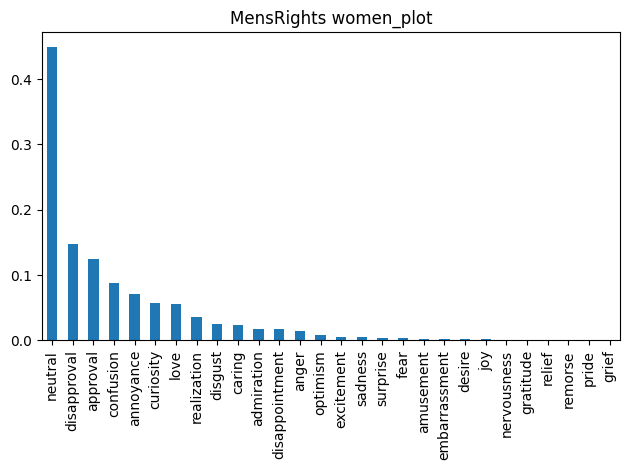

In [ ]:
get_sent_stats(women_sent_df_complex, 'women_plot')

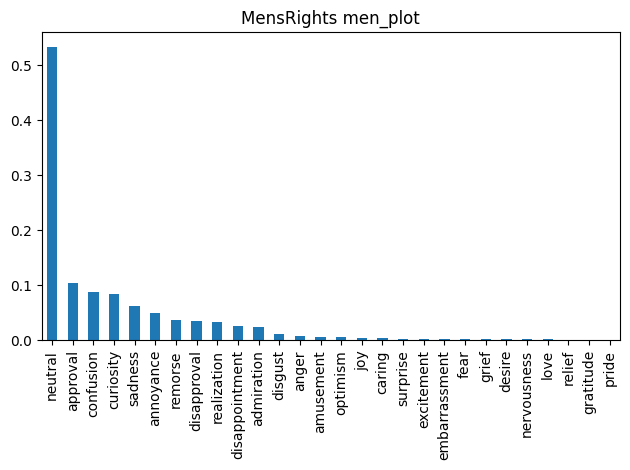

In [ ]:
men_plot = get_sent_stats(men_sent_df_complex, 'men_plot')

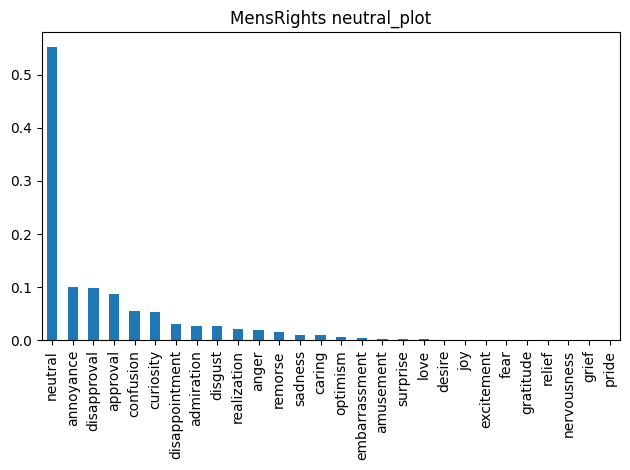

In [ ]:
neutral_plot = get_sent_stats(neutral_sent_df_complex, 'neutral_plot')



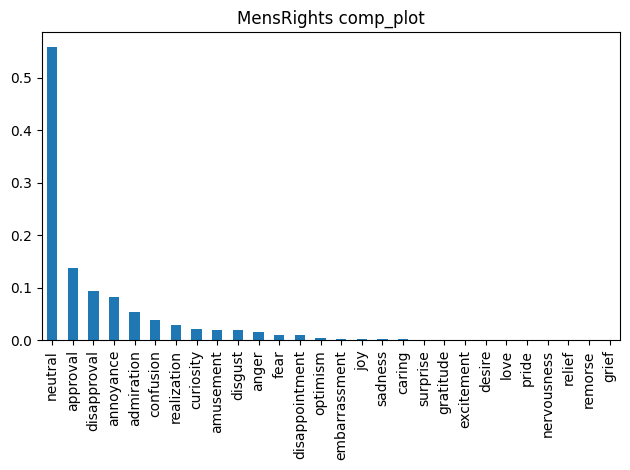

In [ ]:
comp_plot = get_sent_stats(comp_sent_df_complex, 'comp_plot')

#### word counts

In [ ]:
#get counts of words in convos
def count_words(responses: list[str], category : str):
  word_count = {}
  for sentence in responses:
    for word in re.findall(r'\w+|[^\w\s]', sentence):
      if word not in word_count:
          word_count[word] = 1
      else:
          word_count[word] += 1

  word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))
  return word_count


In [ ]:
response_wc = {}

women_response = chats_df['women_response'].dropna().to_list()
response_wc['women'] = count_words(women_response, 'women')

men_response = chats_df['men_response'].dropna().to_list()
response_wc['men'] = count_words(men_response, 'men')

comp_response = chats_df['compare_response'].dropna().to_list()
response_wc['comp'] = count_words(comp_response, 'comp')


neutral_response = chats_df['neutral_response'].dropna().to_list()
response_wc['neutral'] = count_words(neutral_response, 'neutral')

wc_df = pd.DataFrame(response_wc)
wc_df

,women,men,comp,neutral
.,167.0,150.0,69.0,174.0
it,49.0,36.0,11.0,56.0
a,45.0,43.0,22.0,50.0
men,41.0,40.0,22.0,17.0
i,36.0,21.0,9.0,12.0
...,...,...,...,...
specifically,NaN,NaN,NaN,1.0
forward,NaN,NaN,NaN,1.0
privileged,NaN,NaN,NaN,1.0
alcohol,NaN,NaN,NaN,1.0


In [ ]:
wc_df.to_csv(os.path.join(corpus, "training_data", model_name,"word_counts.csv"))